# Zillow Data via Quandl

## Important Imports


In [1]:
# libraries and math functions
import os
import sys
import quandl
import random
import pandas_profiling
import pandas as pd
import numpy as np
from uszipcode import SearchEngine


# imports for pipeline and regression
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# quandl.ApiConfig.api_key = 'rfzykh-NDsw72dmc4Ms4'

In [3]:
# data = quandl.get_table('MER/F1', compnumber="39102", paginate=True)

In [4]:
# quandl.ApiConfig.api_key = 'rfzykh-NDsw72dmc4Ms4'
# quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id='99999')

## Data

In [5]:
data = pd.read_csv("V:\ZILLOW_DATA.csv")
data.head()

,indicator_id,region_id,date,value
0,ZATT,3101,1998-01-31,338849.0
1,ZATT,3101,1998-02-28,342993.0
2,ZATT,3101,1998-03-31,346763.0
3,ZATT,3101,1998-04-30,349356.0
4,ZATT,3101,1998-05-31,351981.0


In [6]:
len(data) #125.5 million lines!!

125528409

In [7]:
data['indicator_id'].unique()

array(['ZATT', 'ZSFH', 'ZALL', 'ZCON', 'ZABT', 'Z5BR', 'Z2BR', 'Z3BR',
       'Z1BR', 'Z4BR', 'ISAW', 'SSAW', 'IRAM', 'CRSM', 'CSSM', 'MSAM',
       'IRAW', 'MRAM', 'SSSW', 'LSSM', 'CSAW', 'ISSM', 'SASW', 'MRAW',
       'LRAM', 'ISSW', 'MSAW', 'LSAM', 'CRAM', 'ISAM', 'IRSM', 'SRSW',
       'LSAW', 'NRAW', 'NSAW', 'CRSW', 'SSAM', 'IRSW', 'NRAM', 'CRAW',
       'LRSM', 'SASM', 'SSSM', 'SAAM', 'LRAW', 'CSAM', 'SRAW', 'CSSW',
       'LRSW', 'SRSM', 'SAAW', 'LSSW', 'SRAM', 'NSAM', 'RSNA', 'RSSA'],
      dtype=object)

In [8]:
rental_data = data[data['indicator_id'].isin(['RSSA', 'RSNA'])] # Just rent
# rental_data = data[data['indicator_id'].isin(['RSSA', 'RSNA', 'Z1BR', 'Z2BR', 'Z3BR'])] # rent and 1-3 bed home values

In [9]:
print(len(rental_data))
print(rental_data.shape)
rental_data.head()

535891
(535891, 4)


,indicator_id,region_id,date,value
1586389,RSNA,102001,2020-06-30,1777.0
1586392,RSNA,394913,2020-06-30,2811.0
1586396,RSNA,753899,2020-06-30,2625.0
1586400,RSNA,394463,2020-06-30,1804.0
1586403,RSNA,394514,2020-06-30,1611.0


In [10]:
print('average rent: ', round(sum(rental_data['value']) / len(rental_data)))

average rent:  1686


## Indicators

In [11]:
indicators = pd.read_csv('V:\ZILLOW_INDICATORS.csv')
indicators.head()

,indicator_id,indicator,category
0,ZATT,ZHVI All Homes- Top Tier Time Series ($),Home values
1,ZSFH,ZHVI Single-Family Homes Time Series ($),Home values
2,ZALL,"ZHVI All Homes (SFR, Condo/Co-op) Time Series ($)",Home values
3,ZCON,ZHVI Condo/Co-op Time Series ($),Home values
4,ZABT,ZHVI All Homes- Bottom Tier Time Series ($),Home values


In [12]:
indicators['indicator_id'].unique()

array(['ZATT', 'ZSFH', 'ZALL', 'ZCON', 'ZABT', 'Z5BR', 'Z2BR', 'Z3BR',
       'Z1BR', 'LSAW', 'NRAW', 'NSAW', 'CRSW', 'SSAM', 'IRSW', 'NRAM',
       'CRAW', 'LRSM', 'SASM', 'SSSM', 'SAAM', 'LRAW', 'CSAM', 'SRAW',
       'CSSW', 'LRSW', 'SRSM', 'SAAW', 'LSSW', 'SRAM', 'NSAM', 'RSNA',
       'RSSA', 'Z4BR', 'ISAW', 'SSAW', 'IRAM', 'CRSM', 'CSSM', 'MSAM',
       'IRAW', 'MRAM', 'SSSW', 'LSSM', 'CSAW', 'ISSM', 'SASW', 'MRAW',
       'LRAM', 'ISSW', 'MSAW', 'LSAM', 'CRAM', 'ISAM', 'IRSM', 'SRSW'],
      dtype=object)

In [13]:
indicators

,indicator_id,indicator,category
0,ZATT,ZHVI All Homes- Top Tier Time Series ($),Home values
1,ZSFH,ZHVI Single-Family Homes Time Series ($),Home values
2,ZALL,"ZHVI All Homes (SFR, Condo/Co-op) Time Series ($)",Home values
3,ZCON,ZHVI Condo/Co-op Time Series ($),Home values
4,ZABT,ZHVI All Homes- Bottom Tier Time Series ($),Home values
5,Z5BR,ZHVI 5+ Bedroom Time Series ($),Home values
6,Z2BR,ZHVI 2-Bedroom Time Series ($),Home values
7,Z3BR,ZHVI 3-Bedroom Time Series ($),Home values
8,Z1BR,ZHVI 1-Bedroom Time Series ($),Home values
9,LSAW,"Median List Price (Smooth, All Homes, Weekly V...",Inventory and sales


In [14]:
indicators['category'].unique()

array(['Home values', 'Inventory and sales', 'Rentals'], dtype=object)

In [15]:
# rentals = indicators[indicators['indicator_id'].isin(['RSSA', 'RSNA', 'Z1BR', 'Z2BR', 'Z3BR', 'Z4BR', 'Z5BR'])]
rentals = indicators[indicators['indicator_id'].isin(['RSSA', 'RSNA'])]
rentals.head()

,indicator_id,indicator,category
31,RSNA,ZORI (Smoothed): All Homes Plus Multifamily Ti...,Rentals
32,RSSA,"ZORI (Smoothed, Seasonally Adjusted): All Home...",Rentals


In [16]:
for item in rentals['indicator_id']:
    print(item)

RSNA
RSSA


In [17]:
print(rentals['indicator'])

31    ZORI (Smoothed): All Homes Plus Multifamily Ti...
32    ZORI (Smoothed, Seasonally Adjusted): All Home...
Name: indicator, dtype: object


## Regions

In [18]:

regions = pd.read_csv('V:\ZILLOW_REGIONS.csv')
regions = regions.sort_values(by=['region_id'])
regions.head(20)

,region_id,region_type,region
1150,3,state,Alaska; AK
453,4,state,Alabama; AL
515,6,state,Arkansas; AR
30,8,state,Arizona; AZ
10,9,state,California; CA
2555,10,state,Colorado; CO
349,11,state,Connecticut; CT
1243,12,state,District of Columbia; DC
1149,13,state,Delaware; DE
11,14,state,Florida; FL


In [19]:
len(regions)

78730

In [20]:
regions['region_type'].unique()

array(['state', 'county', 'city', 'neigh', 'zip', 'metro'], dtype=object)

In [21]:
len(regions['region_type'] == 'metro')


78730

In [22]:
metro = regions[regions['region_type'] == 'metro']
metro[:50]

,region_id,region_type,region
5176,102001,metro,United States
13277,394297,metro,"Aberdeen, SD; SD"
13668,394298,metro,"Aberdeen, WA; WA"
1213,394299,metro,"Abilene, TX; TX"
4449,394300,metro,"Ada, OK; OK"
3469,394302,metro,"Adrian, MI; MI"
1237,394304,metro,"Akron, OH"
5831,394305,metro,"Alamogordo, NM; NM"
2423,394306,metro,"Albany, GA; GA"
2899,394307,metro,"Albany, OR; OR"


# Aggregating Data

In [23]:
# Checking if data has all the same sections
sorted(data['indicator_id'].unique()) == sorted(indicators['indicator_id'].unique())

True

In [24]:
rental_data = rental_data.sort_values(by=['region_id'])
rental_data = rental_data[rental_data['indicator_id'].isin(['RSSA', 'RSNA', 'Z1BR', 'Z2BR', 'Z3BR', 'Z4BR', 'Z5BR', ])]
print(rental_data.shape)
rental_data.head()

(535891, 4)


,indicator_id,region_id,date,value
7851413,RSNA,58362,2020-09-30,1321.0
8747089,RSNA,58362,2020-05-31,1243.0
8747088,RSNA,58362,2020-06-30,1220.0
8747082,RSNA,58362,2020-07-31,1351.0
8753596,RSSA,58362,2020-07-31,1296.0


In [25]:
rent_per_region = pd.merge(rental_data, regions, on='region_id')
rent_per_region.head()

,indicator_id,region_id,date,value,region_type,region
0,RSNA,58362,2020-09-30,1321.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...
1,RSNA,58362,2020-05-31,1243.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...
2,RSNA,58362,2020-06-30,1220.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...
3,RSNA,58362,2020-07-31,1351.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...
4,RSSA,58362,2020-07-31,1296.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...


In [26]:
len(rent_per_region['indicator_id'].unique())

2

In [27]:
rent_per_region[[
    'zip', 'state', 'city', 'county', 'neighborhood'
    ]] = rent_per_region['region'].str.split(';', expand=True)

In [28]:
# test = rent_per_region[::-1]
# test = test[:100]
# test.head(20)

In [29]:
# test[['city', 'state']] = test['region'].str.split(',', expand=True)
# test.head()

In [30]:
rent_per_region[['city', 'state']] = rent_per_region['region'].str.split(',', expand=True)

In [31]:
len(rent_per_region['state'].unique())

42

In [32]:
rent_per_region.isna().sum()

indicator_id         0
region_id            0
date                 0
value                0
region_type          0
region               0
zip                  0
state           517923
city                 0
county          380909
neighborhood    393657
dtype: int64

In [33]:
rent_per_region.shape

(535891, 11)

In [34]:
len(rent_per_region['city'].unique())

4031

In [35]:
rent_per_region = rent_per_region[rent_per_region['zip'].str.contains(r"^\d+$")]

In [36]:
rent_per_region.tail()

,indicator_id,region_id,date,value,region_type,region,zip,state,city,county,neighborhood
535370,RSNA,753844,2014-09-30,989.0,zip,29486,29486,None,29486,None,None
535371,RSNA,753844,2014-08-31,1020.0,zip,29486,29486,None,29486,None,None
535372,RSSA,753844,2014-08-31,997.0,zip,29486,29486,None,29486,None,None
535373,RSNA,753844,2014-12-31,1049.0,zip,29486,29486,None,29486,None,None
535374,RSNA,753844,2015-08-31,1093.0,zip,29486,29486,None,29486,None,None


In [37]:
rent_per_region[rent_per_region['city'].str.contains(r"^\d+$")]

,indicator_id,region_id,date,value,region_type,region,zip,state,city,county,neighborhood
756,RSNA,58449,2020-07-31,1635.0,zip,01610,01610,None,01610,None,None
757,RSNA,58449,2015-08-31,1049.0,zip,01610,01610,None,01610,None,None
758,RSSA,58449,2020-03-31,1338.0,zip,01610,01610,None,01610,None,None
759,RSSA,58449,2020-10-31,1370.0,zip,01610,01610,None,01610,None,None
760,RSNA,58449,2018-10-31,1365.0,zip,01610,01610,None,01610,None,None
...,...,...,...,...,...,...,...,...,...,...,...
535370,RSNA,753844,2014-09-30,989.0,zip,29486,29486,None,29486,None,None
535371,RSNA,753844,2014-08-31,1020.0,zip,29486,29486,None,29486,None,None
535372,RSSA,753844,2014-08-31,997.0,zip,29486,29486,None,29486,None,None
535373,RSNA,753844,2014-12-31,1049.0,zip,29486,29486,None,29486,None,None


## Zip Code doc

In [38]:
zips = pd.read_csv("V:\\uszips.csv")
zips = zips[['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'population', 'density', 'county_name']]
zips.head()

,zip,lat,lng,city,state_id,state_name,population,density,county_name
0,601,18.18005,-66.75218,Adjuntas,PR,Puerto Rico,17113.0,102.7,Adjuntas
1,602,18.36074,-67.17519,Aguada,PR,Puerto Rico,37751.0,476.0,Aguada
2,603,18.45440,-67.12201,Aguadilla,PR,Puerto Rico,47081.0,574.9,Aguadilla
3,606,18.16721,-66.93828,Maricao,PR,Puerto Rico,6392.0,58.3,Maricao
4,610,18.29032,-67.12244,Anasco,PR,Puerto Rico,26686.0,286.9,Añasco


In [39]:
zips['state_id'].unique()

array(['PR', 'VI', 'MA', 'RI', 'NH', 'ME', 'VT', 'CT', 'NY', 'NJ', 'PA',
       'DE', 'DC', 'VA', 'MD', 'WV', 'NC', 'SC', 'GA', 'FL', 'AL', 'TN',
       'MS', 'KY', 'OH', 'IN', 'MI', 'IA', 'WI', 'MN', 'SD', 'ND', 'MT',
       'IL', 'MO', 'KS', 'NE', 'LA', 'AR', 'OK', 'TX', 'CO', 'WY', 'ID',
       'UT', 'AZ', 'NM', 'NV', 'CA', 'HI', 'AS', 'GU', 'MP', 'OR', 'WA',
       'AK'], dtype=object)

In [40]:
values = ['PR', 'VI', 'AS', 'GU', 'MP']

zips = zips[zips['state_id'].isin(values) == False]

In [41]:
len(zips['city'].unique())

17380

In [42]:
zips

,zip,lat,lng,city,state_id,state_name,population,density,county_name
142,1001,42.06259,-72.62589,Agawam,MA,Massachusetts,17312.0,581.0,Hampden
143,1002,42.37492,-72.46210,Amherst,MA,Massachusetts,30014.0,210.5,Hampshire
144,1003,42.39192,-72.52479,Amherst,MA,Massachusetts,11357.0,6164.3,Hampshire
145,1005,42.42017,-72.10615,Barre,MA,Massachusetts,5128.0,44.7,Worcester
146,1007,42.27875,-72.40036,Belchertown,MA,Massachusetts,15005.0,110.1,Hampshire
...,...,...,...,...,...,...,...,...,...
33116,99923,55.97796,-130.03671,Hyder,AK,Alaska,14.0,0.3,Prince of Wales-Hyder
33117,99925,55.55796,-132.97482,Klawock,AK,Alaska,908.0,6.3,Prince of Wales-Hyder
33118,99926,55.12617,-131.48928,Metlakatla,AK,Alaska,1654.0,4.8,Prince of Wales-Hyder
33119,99927,56.25100,-133.37572,Point Baker,AK,Alaska,0.0,0.0,Prince of Wales-Hyder


In [43]:
city_list = pd.read_csv('V:\\cityspire_cities.csv')
print(len(city_list))
city_list.head()

362


,Cities_List
0,"Akron, OH"
1,"Albany, GA"
2,"Albany, NY"
3,"Albany, OR"
4,"Albuquerque, NM"


In [44]:
len(city_list['Cities_List'].unique())

362

In [45]:
city_names = [city.split(",")[0] for city in city_list['Cities_List']]

In [46]:
len(city_names)

362

In [47]:
zips = zips[zips['city'].isin(city_names) == True]
zips

,zip,lat,lng,city,state_id,state_name,population,density,county_name
176,1062,42.32188,-72.69278,Florence,MA,Massachusetts,10364.0,220.4,Hampshire
192,1083,42.20382,-72.19495,Warren,MA,Massachusetts,3094.0,75.8,Worcester
205,1103,42.10400,-72.59210,Springfield,MA,Massachusetts,2332.0,1956.6,Hampden
206,1104,42.13404,-72.56679,Springfield,MA,Massachusetts,23740.0,1757.3,Hampden
207,1105,42.09917,-72.57899,Springfield,MA,Massachusetts,11841.0,3678.4,Hampden
...,...,...,...,...,...,...,...,...,...
33028,99712,64.99326,-146.14966,Fairbanks,AK,Alaska,14837.0,1.6,Fairbanks North Star
33050,99744,64.30627,-149.18016,Anderson,AK,Alaska,120.0,1.4,Denali
33081,99775,64.85849,-147.82472,Fairbanks,AK,Alaska,1180.0,3907.3,Fairbanks North Star
33094,99790,65.42127,-148.28799,Fairbanks,AK,Alaska,20.0,0.0,Yukon-Koyukuk


In [48]:
# Accounting for zip code error with dropped leading 0 (east cost, mostly)
zips['zip'] = zips['zip'].astype(str)
zips['zip'] = zips['zip'].str.zfill(5)

C:\Users\Rob\AppData\Local\Temp/ipykernel_17668/3169711894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zips['zip'] = zips['zip'].astype(str)
C:\Users\Rob\AppData\Local\Temp/ipykernel_17668/3169711894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zips['zip'] = zips['zip'].str.zfill(5)


In [49]:
zips

,zip,lat,lng,city,state_id,state_name,population,density,county_name
176,01062,42.32188,-72.69278,Florence,MA,Massachusetts,10364.0,220.4,Hampshire
192,01083,42.20382,-72.19495,Warren,MA,Massachusetts,3094.0,75.8,Worcester
205,01103,42.10400,-72.59210,Springfield,MA,Massachusetts,2332.0,1956.6,Hampden
206,01104,42.13404,-72.56679,Springfield,MA,Massachusetts,23740.0,1757.3,Hampden
207,01105,42.09917,-72.57899,Springfield,MA,Massachusetts,11841.0,3678.4,Hampden
...,...,...,...,...,...,...,...,...,...
33028,99712,64.99326,-146.14966,Fairbanks,AK,Alaska,14837.0,1.6,Fairbanks North Star
33050,99744,64.30627,-149.18016,Anderson,AK,Alaska,120.0,1.4,Denali
33081,99775,64.85849,-147.82472,Fairbanks,AK,Alaska,1180.0,3907.3,Fairbanks North Star
33094,99790,65.42127,-148.28799,Fairbanks,AK,Alaska,20.0,0.0,Yukon-Koyukuk


In [50]:
zips.to_csv(r'V:\cities_with_zips.csv', index = False)

## Combing datasets on zip codes

In [51]:
rent_per_region.head()

,indicator_id,region_id,date,value,region_type,region,zip,state,city,county,neighborhood
0,RSNA,58362,2020-09-30,1321.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432,None,01432; MA; Boston-Cambridge-Newton; Middlesex ...,Middlesex County,Ayer
1,RSNA,58362,2020-05-31,1243.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432,None,01432; MA; Boston-Cambridge-Newton; Middlesex ...,Middlesex County,Ayer
2,RSNA,58362,2020-06-30,1220.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432,None,01432; MA; Boston-Cambridge-Newton; Middlesex ...,Middlesex County,Ayer
3,RSNA,58362,2020-07-31,1351.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432,None,01432; MA; Boston-Cambridge-Newton; Middlesex ...,Middlesex County,Ayer
4,RSSA,58362,2020-07-31,1296.0,zip,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432,None,01432; MA; Boston-Cambridge-Newton; Middlesex ...,Middlesex County,Ayer


In [52]:
rent_per_region = rent_per_region[['indicator_id', 'date', 'value', 'region', 'zip']]
rent_per_region.head()

,indicator_id,date,value,region,zip
0,RSNA,2020-09-30,1321.0,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432
1,RSNA,2020-05-31,1243.0,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432
2,RSNA,2020-06-30,1220.0,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432
3,RSNA,2020-07-31,1351.0,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432
4,RSSA,2020-07-31,1296.0,01432; MA; Boston-Cambridge-Newton; Middlesex ...,01432


In [53]:
zips.head()

,zip,lat,lng,city,state_id,state_name,population,density,county_name
176,01062,42.32188,-72.69278,Florence,MA,Massachusetts,10364.0,220.4,Hampshire
192,01083,42.20382,-72.19495,Warren,MA,Massachusetts,3094.0,75.8,Worcester
205,01103,42.10400,-72.59210,Springfield,MA,Massachusetts,2332.0,1956.6,Hampden
206,01104,42.13404,-72.56679,Springfield,MA,Massachusetts,23740.0,1757.3,Hampden
207,01105,42.09917,-72.57899,Springfield,MA,Massachusetts,11841.0,3678.4,Hampden


In [54]:
rent_data = rent_per_region.merge(zips, on="zip", how = 'inner')
rent_data.head()

,indicator_id,date,value,region,zip,lat,lng,city,state_id,state_name,population,density,county_name
0,RSNA,2020-08-31,1375.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester
1,RSNA,2020-07-31,1402.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester
2,RSNA,2020-06-30,1439.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester
3,RSNA,2020-11-30,1465.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester
4,RSNA,2020-10-31,1566.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester


In [55]:
rent_data.shape

(213209, 13)

In [56]:
min(rent_data[rent_data['city'] == "Worcester"]['date'])

'2014-01-31'

In [57]:
rent_data['date'] = pd.to_datetime(rent_data['date'])
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213209 entries, 0 to 213208
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   indicator_id  213209 non-null  object        
 1   date          213209 non-null  datetime64[ns]
 2   value         213209 non-null  float64       
 3   region        213209 non-null  object        
 4   zip           213209 non-null  object        
 5   lat           213209 non-null  float64       
 6   lng           213209 non-null  float64       
 7   city          213209 non-null  object        
 8   state_id      213209 non-null  object        
 9   state_name    213209 non-null  object        
 10  population    213209 non-null  float64       
 11  density       213209 non-null  float64       
 12  county_name   213209 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 22.8+ MB


In [58]:
rent_data['year'] = pd.DatetimeIndex(rent_data['date']).year
rent_data['month'] = pd.DatetimeIndex(rent_data['date']).month
rent_data['day'] = pd.DatetimeIndex(rent_data['date']).day
rent_data.head()

,indicator_id,date,value,region,zip,lat,lng,city,state_id,state_name,population,density,county_name,year,month,day
0,RSNA,2020-08-31,1375.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester,2020,8,31
1,RSNA,2020-07-31,1402.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester,2020,7,31
2,RSNA,2020-06-30,1439.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester,2020,6,30
3,RSNA,2020-11-30,1465.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester,2020,11,30
4,RSNA,2020-10-31,1566.0,01603; MA; Worcester; Worcester County,01603,42.24407,-71.84445,Worcester,MA,Massachusetts,19731.0,1688.4,Worcester,2020,10,31


In [59]:
rent_data.shape

(213209, 16)

In [60]:
rent_data.columns

Index(['indicator_id', 'date', 'value', 'region', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'population', 'density', 'county_name',
       'year', 'month', 'day'],
      dtype='object')

In [61]:
rent_data = rent_data[['value', 'region', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'population', 'density', 'county_name',
       'year', 'month', 'day']]

In [62]:
rent_data.to_csv(r'V:\cleaned_rent_data.csv', index = False)

# Preliminary visualizations

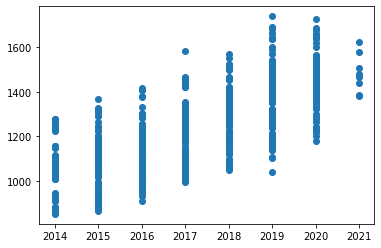

In [63]:
# This shows the change but it's a little muddy
x = rent_data[rent_data['city'] == "Worcester"]['year']
y = rent_data[rent_data['city'] == "Worcester"]['value']

plt.scatter(x, y);

In [64]:
# Box plots to show change over time

# for city in rent_data['city'].unique():
#     x = rent_data[rent_data['city'] == city]['date'].dt.year
#     y = rent_data[rent_data['city'] == city]['value']

#     sns.boxplot(x=x, y=y, data=rent_data)
#     plt.title(city)
#     plt.xlabel("Change Over Years")
#     plt.ylabel("Price Range")
#     plt.show()

# QUANDL API for the same data to maintain in real time

In [65]:
# quandl.ApiConfig.api_key = 'rfzykh-NDsw72dmc4Ms4'
# data_rssa = quandl.get_table('ZILLOW/DATA', indicator_id='RSSA')
# data_rsna = quandl.get_table('ZILLOW/DATA', indicator_id='RSNA')
# data = data_rssa.append(data_rsna)
# data.head()

In [66]:
# data.shape

In [67]:
# indicators = quandl.get_table('ZILLOW/INDICATORS', indicator_id=['RSSA', 'RSNA'])
# indicators.head()

In [68]:
# regions = quandl.get_table('ZILLOW/REGIONS')
# regions.head()

In [69]:
# regions = regions.sort_values(by=['region_id'])
# regions.head(10)

In [70]:
# sorted(data['indicator_id'].unique()) == sorted(indicators['indicator_id'].unique())

In [71]:
# rent_per_region = pd.merge(data, regions, on='region_id', sort=True, how='inner')
# rent_per_region

In [72]:
# rent_per_region.shape

In [73]:
# rent_per_region[[
#     'zip', 'state', 'city', 'county', 'neighborhood'
#     ]] = rent_per_region['region'].str.split(';', expand=True)

In [74]:
# rent_per_region.head(10)

# Predictive Modeling

In [75]:
rent_data.columns

Index(['value', 'region', 'zip', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'population', 'density', 'county_name', 'year', 'month',
       'day'],
      dtype='object')

In [76]:
rent_data.isna().sum()

value          0
region         0
zip            0
lat            0
lng            0
city           0
state_id       0
state_name     0
population     0
density        0
county_name    0
year           0
month          0
day            0
dtype: int64

In [77]:
def simple_preprocess(df):
  
  numeric = df.copy().select_dtypes(include= "number").columns
  categorical = df.copy().select_dtypes(exclude = "number").columns
  
  c_steps = [('c_imputer', SimpleImputer(strategy="most_frequent"))]
  c_pipeline = Pipeline(c_steps)
  
  n_steps = [('n_imputer', SimpleImputer())]
  n_pipeline = Pipeline(n_steps)
  
  df[numeric] = n_pipeline.fit_transform(df[numeric])
  df[categorical] = c_pipeline.fit_transform(df[categorical])
  
  return df

In [78]:
rent_data = simple_preprocess(rent_data)

In [79]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213209 entries, 0 to 213208
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   value        213209 non-null  float64
 1   region       213209 non-null  object 
 2   zip          213209 non-null  object 
 3   lat          213209 non-null  float64
 4   lng          213209 non-null  float64
 5   city         213209 non-null  object 
 6   state_id     213209 non-null  object 
 7   state_name   213209 non-null  object 
 8   population   213209 non-null  float64
 9   density      213209 non-null  float64
 10  county_name  213209 non-null  object 
 11  year         213209 non-null  float64
 12  month        213209 non-null  float64
 13  day          213209 non-null  float64
dtypes: float64(8), object(6)
memory usage: 24.4+ MB


In [80]:
rent_data.columns

Index(['value', 'region', 'zip', 'lat', 'lng', 'city', 'state_id',
       'state_name', 'population', 'density', 'county_name', 'year', 'month',
       'day'],
      dtype='object')

In [81]:
# NOTE: Still working on this and how to approach prediction
# May use a neural net or pipeline to do this


# Setting target and features
target = 'value'
features = rent_data.drop('value', axis=1).columns

X = rent_data[features]
y = rent_data[target]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# # Train / Val split 
# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, test_size=0.20, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape # X_val.shape, y_val.shape,

((170567, 13), (170567,), (42642, 13), (42642,))

In [82]:
X_train.columns, X_test.columns

(Index(['region', 'zip', 'lat', 'lng', 'city', 'state_id', 'state_name',
        'population', 'density', 'county_name', 'year', 'month', 'day'],
       dtype='object'),
 Index(['region', 'zip', 'lat', 'lng', 'city', 'state_id', 'state_name',
        'population', 'density', 'county_name', 'year', 'month', 'day'],
       dtype='object'))

In [83]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    LinearRegression(n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))


Validation Accuracy 0.32768583400934825
